In [ ]:
import json
import urllib
import requests
import numpy as np
import tensorflow as tf


# Loading Data

In [ ]:
#Fetching data

##Conecction
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I', # This is the fake app's application id
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK' # This is the fake app's readonly master key
}

def fetchUrl(skip:int,limit:int):
  url ='https://parseapi.back4app.com/classes/NamesList?skip='+ str(skip)+'&limit='+ str(limit)+'&order=Name&excludeKeys=Letter'
  data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need
  return data['results']

##Creating skip walkpath
step=100;
limit=6000
walkpath = np.array(range(0,limit,step))
## mapping fetching
data = np.array(list(map(fetchUrl,walkpath,[limit]))).flatten()

##fetching names
nameList = list(map(lambda item:item['Name'],data))
genderList = list(map(lambda item:item['Genre'],data))
print(len(nameList))

6000


## Pre-procesing data

In [ ]:
##Normalizing list for Machine Learning with values between 0 and 1
from typing import Union, List

###Genre
def genreNormalizer(genre:str)->int:
  if genre == 'female':
    x = 1
  else:
    x = 0
  return x

genderTensorList = list(map(genreNormalizer,genderList))

###Names
#return array float size 20
chars:List[str] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','ñ','o','p','q','r','s','t','u','v','w','x','y','z']
def nameNormalizer(name:str)->List[float]:
  splitedName = list(name.lower())
  descriteName = list(map(lambda char:chars.index(char)/len(chars),splitedName))
  box = [0.0]*(20-len(descriteName))
  input = np.concatenate((np.array(box),np.array(descriteName)))
  return list(input.flatten())

nameTensorList = list(map(nameNormalizer,nameList))

## Configurating Neuronal Nextwork

In [ ]:
#model configuration
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(20,1)),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax'),
])

In [ ]:
#model compiling
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#train model
modeling = model.fit(nameTensorList,genderTensorList,epochs=100,verbose=False)

188/188 - 0s - loss: 0.2839 - accuracy: 0.8702 - 356ms/epoch - 2ms/step

Test accuracy: 0.8701666593551636


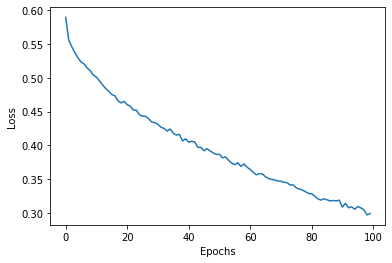

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(modeling.history['loss'])

test_loss, test_acc = model.evaluate(nameTensorList,  genderTensorList, verbose=2)

print('\nTest accuracy:', test_acc)

In [141]:
# Predict
def genderProbability(name:str):
  gender = ['male','female']
  input = nameNormalizer(name)
  prediction = model.predict([input])[0]
  category = gender[np.argmax(prediction)] 

  return (category,str(round(np.max(prediction)*100,2))+'%')

print(genderProbability('Norman'))

('male', '97.46%')
